# **Titanic Disaster Analysis**

**Goal:** This project aims to analyze the scenario from Titanic disaster dataset from Kaggle.

**Dataset:** https://www.kaggle.com/c/titanic/data

# **Importing Necessary Libraries**

In [1]:
pip install pandas

In [2]:
pip install openpyxl

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Retrieving Data**

In [4]:
import pandas as pd

df = pd.read_excel('/content/drive/My Drive/Train.xlsx', sheet_name = 'Train')
print(df.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

# **Data Cleaning**

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [7]:
# Check for outliers
import numpy as np

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Compute Q1, Q3, and IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and print outliers for each numeric column
for col in numeric_cols.columns:
    outliers = df[(df[col] < lower_bound[col]) | (df[col] > upper_bound[col])]
    if not outliers.empty:
        print(f"\nOutliers in '{col}':")
        print(outliers[[col]])


Outliers in 'Age':
      Age
33   66.0
54   65.0
96   71.0
116  70.5
280  65.0
456  65.0
493  71.0
630  80.0
672  70.0
745  70.0
851  74.0

Outliers in 'SibSp':
     SibSp
7        3
16       4
24       3
27       3
50       4
59       5
63       3
68       4
71       5
85       3
88       3
119      4
159      8
164      4
171      4
176      3
180      8
182      4
201      8
229      3
233      4
261      4
266      4
278      4
324      8
341      3
374      3
386      5
409      3
480      5
485      3
541      4
542      4
634      3
642      3
683      5
686      4
726      3
787      4
792      8
813      4
819      3
824      4
846      8
850      4
863      8

Outliers in 'Parch':
     Parch
7        1
8        2
10       1
13       5
16       1
..     ...
871      1
879      1
880      1
885      5
888      2

[213 rows x 1 columns]

Outliers in 'Fare':
         Fare
1     71.2833
27   263.0000
31   146.5208
34    82.1708
52    76.7292
..        ...
846   69.5500
849   89.1

In [8]:
# Cap the outliers
df_capped = df.copy()
for col in numeric_cols.columns:
    df_capped[col] = np.where(df_capped[col] < lower_bound[col], lower_bound[col], df_capped[col])
    df_capped[col] = np.where(df_capped[col] > upper_bound[col], upper_bound[col], df_capped[col])

# Display the descriptive statistics and data types of the capped dataframe
print(df_capped.describe())
print(df_capped.dtypes)

       PassengerId    Survived      Pclass         Age       SibSp  Parch  \
count   891.000000  891.000000  891.000000  714.000000  891.000000  891.0   
mean    446.000000    0.383838    2.308642   29.622700    0.426487    0.0   
std     257.353842    0.486592    0.836071   14.316665    0.708246    0.0   
min       1.000000    0.000000    1.000000    0.420000    0.000000    0.0   
25%     223.500000    0.000000    2.000000   20.125000    0.000000    0.0   
50%     446.000000    0.000000    3.000000   28.000000    0.000000    0.0   
75%     668.500000    1.000000    3.000000   38.000000    1.000000    0.0   
max     891.000000    1.000000    3.000000   64.812500    2.500000    0.0   

             Fare  
count  891.000000  
mean    24.046813  
std     20.481625  
min      0.000000  
25%      7.910400  
50%     14.454200  
75%     31.000000  
max     65.634400  
PassengerId    float64
Survived       float64
Pclass         float64
Name            object
Sex             object
Age        

In [9]:
# Identify duplicate rows
duplicates = df[df.duplicated()]
print("Duplicate Rows:\n", duplicates)

duplicate_rows = df[df.duplicated()]
print("Duplicate Rows:", len(duplicate_rows))

Duplicate Rows:
 Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []
Duplicate Rows: 0


In [10]:
# Detect duplicate columns
def duplicate_columns(data):
    duplicate_cols = []
    cols_seen = {}

    # Loop through all columns and compare their data
    for col in data.columns:
        col_data = tuple(data[col])
        if col_data in cols_seen:
            duplicate_cols.append(col)
        else:
            cols_seen[col_data] = col

    return duplicate_cols

# Identify duplicate columns
duplicates = duplicate_columns(df)
print("Duplicate Columns:", duplicates)

Duplicate Columns: []


In [11]:
# Define a function to categorize age
# Child: Age < 18 years
# Adult: Age < 65 years
# Senior: Age >= 65 years

def categorize_age(age):
    if age < 18:
        return 'Child'
    elif age < 65:
        return 'Adult'
    else:
        return 'Senior'

# Apply the function to create a new column
df['Age_Group'] = df['Age'].apply(categorize_age)

print(df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [12]:
summary = df.describe()
print(summary)

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [13]:
data_types = df.dtypes
print(data_types)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Age_Group       object
dtype: object


# **Exploratory Data Analysis (EDA)**

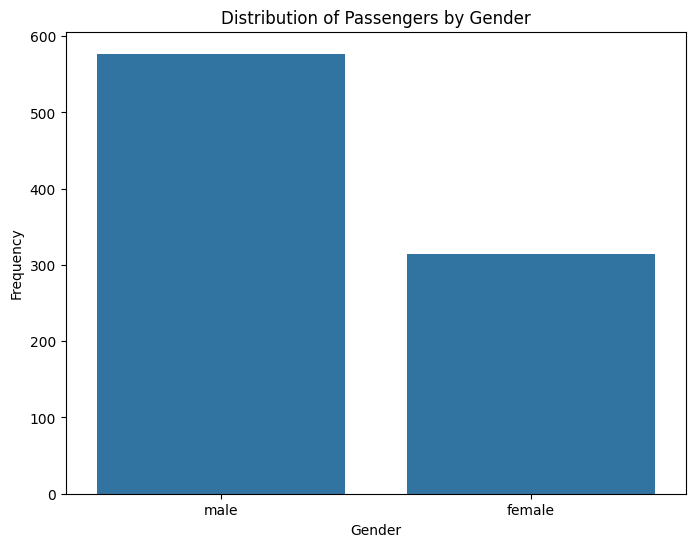

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot
plt.figure(figsize = (8, 6))
sns.countplot(x = 'Sex', data = df_capped)
plt.title('Distribution of Passengers by Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Age Distribution Histogram')

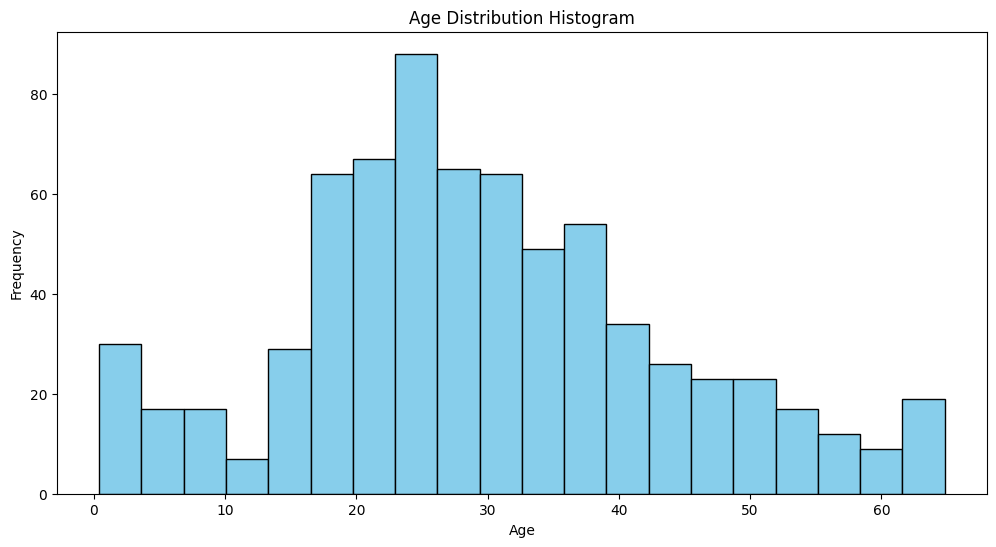

In [15]:
# Histogram for age distribution

plt.figure(figsize = (12, 6))
plt.hist(df_capped['Age'], bins = 20, color = 'skyblue', edgecolor = 'black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution Histogram')

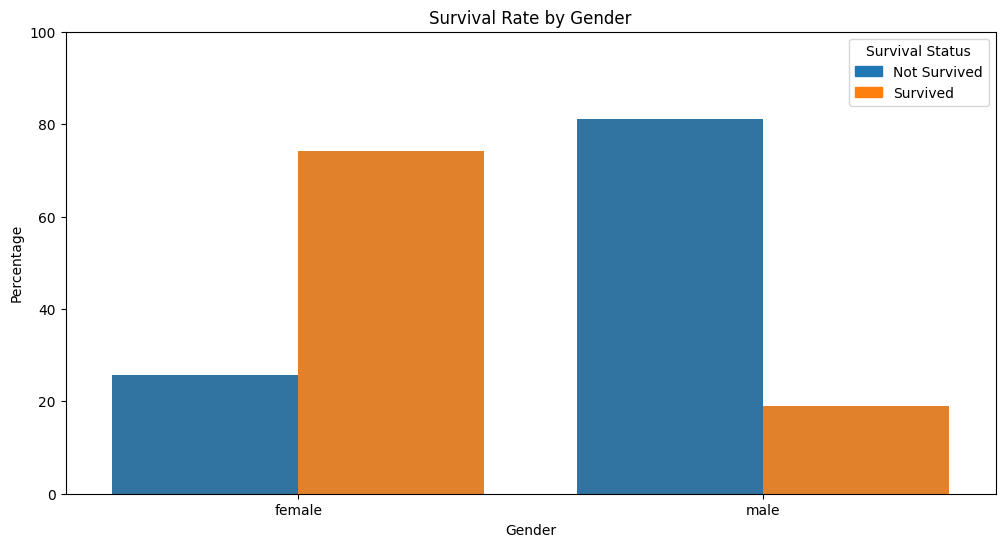

In [16]:
# Calculate survival percentages by gender
gender_survival = df_capped.groupby(['Sex', 'Survived']).size().reset_index(name = 'Count')
gender_survival['Percentage'] = gender_survival['Count'] / gender_survival.groupby('Sex')['Count'].transform('sum') * 100

# Plot percentage of survival by gender
plt.figure(figsize = (12, 6))
sns.barplot(x = 'Sex', y = 'Percentage', hue = 'Survived', data = gender_survival)
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.ylim(0, 100)

# Create custom legend
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color = sns.color_palette()[0], label = 'Not Survived'),mpatches.Patch(color = sns.color_palette()[1], label = 'Survived')]
plt.legend(handles = handles, title = 'Survival Status', loc = 'upper right')

plt.show()

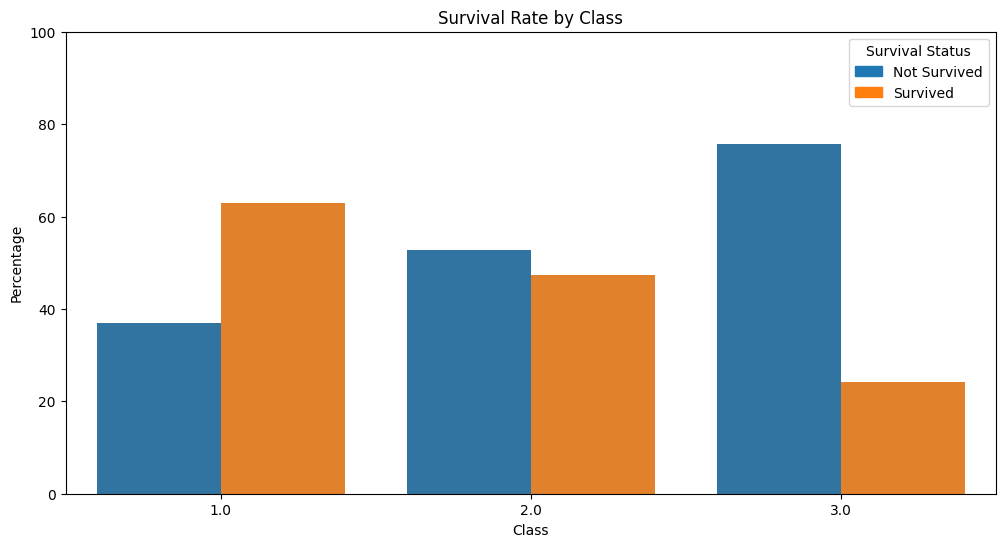

In [17]:
# Calculate survival percentages by class
class_survival = df_capped.groupby(['Pclass', 'Survived']).size().reset_index(name = 'Count')
class_survival['Percentage'] = class_survival['Count'] / class_survival.groupby('Pclass')['Count'].transform('sum') * 100

# Plot percentage of survival by class
plt.figure(figsize = (12, 6))
sns.barplot(x = 'Pclass', y = 'Percentage', hue = 'Survived', data = class_survival)
plt.title('Survival Rate by Class')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.ylim(0, 100)

# Create custom legend
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color = sns.color_palette()[0], label = 'Not Survived'),mpatches.Patch(color = sns.color_palette()[1], label = 'Survived')]
plt.legend(handles = handles, title = 'Survival Status', loc = 'upper right')

plt.show()

# **Statistical Analysis**

In [18]:
# Calculate the mean, median, and mode for the 'Fare' column

mean_value = df['Fare'].mean()
median_value = df['Fare'].median()
mode_value = df['Fare'].mode()

print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value.tolist()}")

Mean: 32.204207968574636
Median: 14.4542
Mode: [8.05]


In [19]:
# Calculate the mean, median, and mode for the 'Age' column

mean_value = df['Age'].mean()
median_value = df['Age'].median()
mode_value = df['Age'].mode()

print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value.tolist()}")

Mean: 29.69911764705882
Median: 28.0
Mode: [24.0]


In [20]:
# Perform a t-test to determine if there's a significant difference in survival rate based on gender

from scipy import stats

# Separate the groups
male_survival = df[df['Sex'] == 'male']['Survived']
female_survival = df[df['Sex'] == 'female']['Survived']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(male_survival, female_survival, equal_var = False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference in survival rates.")
else:
    print("Fail to reject the null hypothesis: No significant difference in survival rates.")

T-statistic: -18.67183317725917, P-value: 2.2836009226010533e-61
Reject the null hypothesis: Significant difference in survival rates.
